In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random
from matplotlib import pyplot
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, SeparableConv2D, BatchNormalization, MaxPooling2D, Dense, Dropout, Flatten, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
import os
import zipfile
from os import path

In [ ]:
def unzip_samples(file = "data.zip", overwrite = False):
    if not os.path.exists(os.path.splitext(file)[0]) or overwrite:
        with zipfile.ZipFile(file, 'r') as zip_ref:
            zip_ref.extractall(".")

def generate_datasets(zip_data_path = "data.zip", train_set_path = "train_set", test_set_path = "test_set", validation_set_path = "validation_set", channels = 4):
    unzip_samples(zip_data_path)
    generate_tensors(train_set_path, sample_start = 1, sample_end = 200, channels = channels)
    generate_tensors(test_set_path, sample_start = 201, sample_end = 250, channels = channels)
    generate_tensors(validation_set_path, sample_start = 251, sample_end = 300, channels = channels)

def sample_path(class_name, sample, channel):
    png_path = "data/" + class_name + "/dat_ch" + str(channel) + "_" + str(sample) + ".png"
    return png_path

def show_sample(class_name, sample):
    print("Sample = {}, class = {}".format(sample, class_name))
    fig, ax = plt.subplots(1, 4)
    fig.set_figwidth(10)
    fig.set_figheight(10)
    for i in range(4):
        im = Image.open(sample_path(class_name = class_name, sample = sample, channel = i+1), "r")
        ax[i].set_title("Ch {}".format(i+1))
        ax[i].imshow(im)
    fig.show()

def show_grid(sample, channels = 4):
    print("Grid (sample = {}, channels = {})".format(sample, channels))
    fig, ax = plt.subplots(4, 4)
    fig.set_figwidth(10)
    fig.set_figheight(12)
    matrix = np.zeros((32, 32, channels), dtype="uint8")
    for row in range(4):
        for col in range(4):
            class_name = "A" + str(row + 1) + str(col + 1)
            for ch in range(channels):
                matrix[:, :, ch] = np.array(Image.open(sample_path(class_name = class_name, sample = sample, channel = ch + 1), "r"))
            ax[row, col].set_title(class_name)
            ax[row, col].imshow(matrix)
    plt.show()

def generate_sample_tensor(class_name = "A11", sample = 1, channels = 4):
    tensor = np.zeros((32, 32, channels), dtype="uint8")
    for ch in range(channels):
        tensor[:, :, ch] = np.array(Image.open(sample_path(class_name = class_name, sample = sample, channel = ch + 1), "r"))
    return tensor

def generate_tensors(dest_path = "tensors", sample_start = 1, sample_end = 300, channels = 4, overwrite = False):
    if not os.path.exists(dest_path) or overwrite:
        for row in range(4):
            for col in range(4):
                class_name = "A" + str(row + 1) + str(col + 1)
                path = os.path.join(dest_path, class_name)
                if not os.path.exists(path):
                    os.makedirs(path)
                for i in range(sample_start, sample_end + 1):
                    file_name = os.path.join(path, "data_" + str(i))
                    tensor = generate_sample_tensor(class_name = class_name, sample = i, channels = channels)
                    np.save(file_name, tensor)

def create_labeled_data(srs_path = "tensors", label_type = "categorical"):
    labeled_data = []
    categories = os.listdir(srs_path)
    categories.sort()
    for category in categories:
        path = os.path.join(srs_path, category)  # create path to the classes
        class_num = categories.index(category)  # get the classification  0 = A11, 1 = A12, 2 = A13, ...etc

        file_list = os.listdir(path)
        file_list.sort()
        for file in file_list:
            file = os.path.join(path, file)
            sample = np.load(file)
            labeled_data.append([sample, class_num])

    random.shuffle(labeled_data)

    X = []
    Y = []
    for sample, label in labeled_data:
        X.append(sample)
        Y.append(label)

    X = np.array(X)
    X = X.astype("float32")/255

    Y = np.array(Y)
    np.reshape(Y, (len(Y), 1))

    if label_type == "regression":
        Y = to_regression(Y)
    else:
        Y = to_categorical(Y)

    return X, Y

def to_regression(category_index, max_row = 4, max_col = 4):
    col = category_index % max_col
    row = (category_index - col) // max_row
    x_pos = (1.0/max_col) * (col + 1) - (0.5/max_col)
    y_pos = (1.0/max_row) * (row + 1) - (0.5/max_row)
    tensor = np.array(list(map(lambda x, y:[x,y], x_pos, y_pos)))
    return tensor

def get_category(distributions, max_row = 4, max_col = 4):
    category_index = distributions.argmax()

    col = category_index % max_col
    row = int((category_index - col) / max_row)
    category = "A" + str(row + 1) + str(col + 1)
    return category

def optimization_plot(history, filename):
    # plot loss
    f = pyplot.figure()
    f.set_figwidth(10)
    f.set_figheight(20)

    pyplot.subplot(211)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(history.history['loss'], color='blue', label='train')
    pyplot.plot(history.history['val_loss'], color='orange', label='test')
    # plot accuracy
    pyplot.subplot(212)
    pyplot.title('Classification Accuracy')
    pyplot.plot(history.history['accuracy'], color='blue', label='train')
    pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
    # save plot to file
    pyplot.savefig(filename + '.png')
    pyplot.close()

def train_model(model, model_file_name = "model.h5", target_accuracy = 0.90):
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, verbose=1, mode='auto', restore_best_weights=True)

    current_accuracy = 0
    while (current_accuracy < target_accuracy):
        history = model.fit(train_X, train_Y, epochs=5, batch_size=10, validation_data=(test_X, test_Y), verbose=1, callbacks=[monitor])
        _, validation_accuracy = model.evaluate(val_X, val_Y, verbose=1)
        if (current_accuracy < validation_accuracy):
            print("Validation accuracy > {:.2f}".format(validation_accuracy * 100.0))
            print("Saving model > {}".format(model_file_name))
            model.save(model_file_name)
            optimization_plot(history, "optimization")
            current_accuracy = validation_accuracy
        else:
            if os.path.exists(model_file_name):
                model = load_model(model_file_name)

    print("Done!")

In [ ]:
def CNN_regression(input_shape = (32, 32, 4), output_regression = 2):
    model = Sequential()

    model.add(Conv2D(40, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape = input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(60, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(120, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(output_regression, activation='sigmoid'))
    # compile model
    #opt = SGD(learning_rate=0.001, momentum=0.9)
    opt = "adam"
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
def CNN_categorical(input_shape = (32, 32, 4), output_categories = 16):
    model = Sequential()

    model.add(Conv2D(40, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape = input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(60, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(120, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(output_categories, activation='softmax'))
    # compile model
    #opt = SGD(learning_rate=0.001, momentum=0.9)
    opt = "adam"
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
zip_data_path = "data.zip"
train_set_path = "train_set"
test_set_path = "test_set"
validation_set_path = "validation_set"

channel_sensors = 4

generate_datasets (zip_data_path, train_set_path, test_set_path, validation_set_path, channels = channel_sensors)

In [ ]:
model_type = "regression" # set "regression" or "categorical"

train_X, train_Y = create_labeled_data(srs_path = train_set_path, label_type = model_type)
test_X, test_Y = create_labeled_data(srs_path = test_set_path, label_type = model_type)
val_X, val_Y = create_labeled_data(srs_path = validation_set_path, label_type = model_type)


In [ ]:
test_X.shape

(800, 32, 32, 4)

In [ ]:
if model_type == "regression":
    model = CNN_regression(input_shape = (32, 32, channel_sensors))
else:
    model = CNN_categorical(input_shape = (32, 32, channel_sensors), output_categories = 16)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 40)        1480      
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 40)       160       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 40)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 40)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 60)        21660     
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 60)       2

In [ ]:
model_file_name = "model.h5" # Set the file name for the model
target_accuracy = 0.90

train_model(model, model_file_name, target_accuracy)

Epoch 1/5
320/320 [==============================] - 16s 8ms/step - loss: 0.6959 - accuracy: 0.7722 - val_loss: 0.5546 - val_accuracy: 0.9050
Epoch 2/5
320/320 [==============================] - 2s 7ms/step - loss: 0.5886 - accuracy: 0.8112 - val_loss: 0.5423 - val_accuracy: 0.9087
Epoch 3/5
320/320 [==============================] - 2s 7ms/step - loss: 0.5553 - accuracy: 0.8278 - val_loss: 0.5336 - val_accuracy: 0.8425
Epoch 4/5
320/320 [==============================] - 2s 7ms/step - loss: 0.5433 - accuracy: 0.8478 - val_loss: 0.5337 - val_accuracy: 0.9388
Epoch 5/5
25/25 [==============================] - 0s 5ms/step - loss: 0.5287 - accuracy: 0.9250
Validation accuracy > 92.50
Saving model > model.h5
Done!


In [ ]:
file = validation_set_path + "/A43/data_289.npy"

sample = np.load(file)
sample = sample.astype('float32') / 255.0
sample = np.expand_dims(sample, axis=0)

model = load_model(model_file_name)

model_output = model.predict(sample)

if model_type == "regression":
    print("Input sample = {}, model prediction = {}".format(file, model_output))
else:
    print("Input sample = {}, model prediction = {}".format(file, get_category(model_output)))

Input sample = validation_set/A43/data_289.npy, model prediction = [[0.58936447 0.85706854]]


Grid (sample = 280, channels = 4)


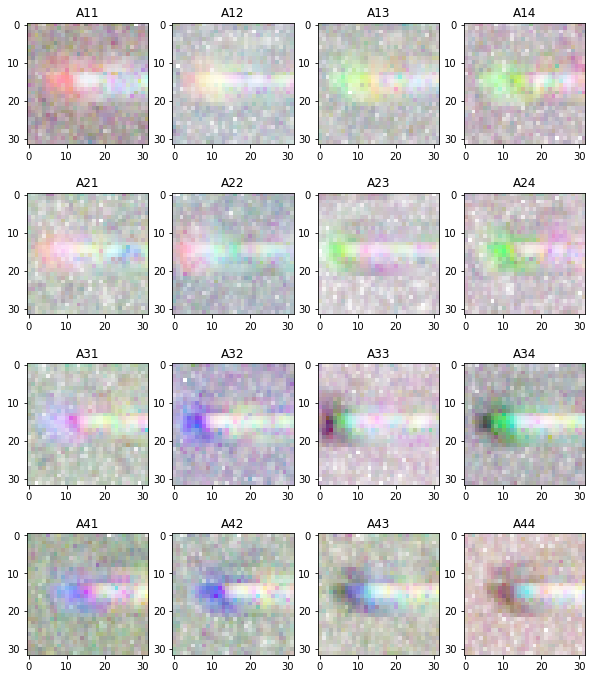

In [ ]:
show_grid(sample = 280)

Sample = 280, class = A21


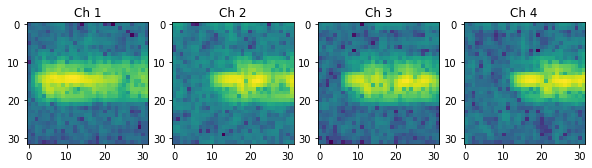

In [ ]:
show_sample(class_name = "A21", sample = 280)

In [ ]:
def save_numpy_array(array : np.ndarray = None, folder_name: str = "exported_data") -> None:
  if not path.exists(folder_name):
    os.mkdir(folder_name)
  # File name incrementor
  i = 0
  for each_element in array:
    i += 1
    np.save(f"{folder_name}/{str(i)}", each_element)
    if i==1:
      # Check dimension of the array element
      print("Shape of the each element: ")
      print(each_element.shape)

In [ ]:
save_numpy_array(test_X, folder_name="test_X")

(32, 32, 4)


In [ ]:
save_numpy_array(test_Y, folder_name="somefolder")

Shape of the each element: 
(2,)


In [ ]:
def zipdir(path, ziph):
    # ziph is zipfile handle
    for root, dirs, files in os.walk(path):
        for file in files:
            ziph.write(os.path.join(root, file), 
                       os.path.relpath(os.path.join(root, file), 
                                       os.path.join(path, '..')))

In [ ]:
zipf = zipfile.ZipFile('test_X.zip', 'w', zipfile.ZIP_DEFLATED)
zipdir('test_X', zipf)
zipf.close()

In [ ]:
zipf = zipfile.ZipFile('test_Y.zip', 'w', zipfile.ZIP_DEFLATED)
zipdir('test_Y', zipf)
zipf.close()